In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd

os.getlogin()

'matto'

In [2]:
path = r"C:\Users\matto\Desktop\School Choice"
data = os.path.join(path, "Data")

zip_path = os.path.join(data, "tl_2020_us_zcta520") 
district_shape_path = os.path.join(data, "TL_2022_SD") 

output = os.path.join(path, "Output")

## CTD ADM Dictionary

In [3]:
ctd_adm = pd.read_csv(os.path.join(data, "SchoolInfo.csv"))
ctd_adm_grade_dict = dict(zip(ctd_adm['EntityID'], ctd_adm['Grades']))
ctd_adm_type_dict = dict(zip(ctd_adm['EntityID'], ctd_adm['Entity_Type']))
ctd_adm_name_dict = dict(zip(ctd_adm['EntityID'], ctd_adm['Name']))

In [4]:
ctds_adm = pd.read_csv(os.path.join(data, "CTDS_ADM_FY_22.csv"))
ctds_adm_grade_dict = dict(zip(ctd_adm['EntityID'], ctd_adm['Grades']))
ctds_adm_type_dict = dict(zip(ctd_adm['EntityID'], ctd_adm['Entity_Type']))
ctds_adm_name_dict = dict(zip(ctd_adm['EntityID'], ctd_adm['Name']))

In [5]:
letter = pd.ExcelFile(os.path.join(data, "FY20Combined20Public202023-06-26.xlsx"))
letter.sheet_names

grades = pd.DataFrame()

for sheet in ['Traditional K-8 Schools','Traditional 9-12 Schools','Traditional Hybrid Schools','Alternative Schools']:
    temp = pd.read_excel(os.path.join(data, "FY20Combined20Public202023-06-26.xlsx"), sheet_name = sheet)
    temp = temp[['School Name','School Code','Letter Grade','Model']]
    grades = pd.concat([grades, temp])

In [6]:
letter_grade_dict = dict(zip(grades['School Code'], grades['Letter Grade']))

## ELSI

In [8]:
edge = pd.read_csv(os.path.join(data,"ELSI_csv_export_6383927981376258893363.csv"), 
                   skiprows = 6)

edge.drop(columns = ['School Name'], inplace = True)

edge.columns = [c.replace("[Public School] Latest available year","") for c in edge.columns]
edge.columns = [c.replace("[Public School] 2021-22","") for c in edge.columns]
edge.columns = [c.replace("(SY 2017-18 onward) ","") for c in edge.columns]
edge.columns = [c.strip() for c in edge.columns]

edge['LEAID'] = edge['State School ID'].str.split("-").str[-2]
edge['State School ID'] = edge['State School ID'].str.split("-").str[-1]

edge = edge[edge['State School ID'].notnull()]

edge['LEA Type'] = edge['LEAID'].astype(int).map(ctd_adm_type_dict)
edge['LEA Grade'] = edge['LEAID'].astype(int).map(ctd_adm_grade_dict)
edge['LEA Name'] = edge['LEAID'].astype(int).map(ctd_adm_name_dict)

edge['Letter'] = edge['State School ID'].astype(int).map(letter_grade_dict)

edge_gdf = gpd.GeoDataFrame(edge, geometry = gpd.points_from_xy(edge.Longitude, edge.Latitude))
edge_gdf.set_crs("EPSG:4269", inplace = True)
edge_gdf

,State Name,School Name,School ID - NCES Assigned,Latitude,Longitude,State School ID,State Agency ID,School Level,LEAID,LEA Type,LEA Grade,LEA Name,Letter,geometry
0,Arizona,A J Mitchell Elementary School,4.055300e+10,31.347700,-110.938900,5958,AZ-4457,Elementary,4457,District,'PK-12,Nogales Unified District,B,POINT (-110.93890 31.34770)
1,ARIZONA,A+ Charter Schools,4.009980e+10,33.042533,-112.015895,1000972,AZ-1000166,High,1000166,Charter Holder,'7-12,A+ Charter Schools,B,POINT (-112.01590 33.04253)
2,Arizona,A. C. E.,4.046300e+10,32.453107,-111.207690,5768,AZ-4404,High,4404,District,'PK-12,Marana Unified District,NaN,POINT (-111.20769 32.45311)
3,Arizona,AAEC - Paradise Valley,4.001060e+10,33.654305,-112.001380,6344,AZ-4331,High,4331,Charter Holder,'9-12,"Arizona Agribusiness & Equine Center, Inc.",A,POINT (-112.00138 33.65431)
4,Arizona,AAEC - SMCC Campus,4.004170e+10,33.378982,-112.039907,5503,AZ-85816,High,85816,Charter Holder,'9-12,"Arizona Agribusiness & Equine Center, Inc.",B,POINT (-112.03991 33.37898)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,ARIZONA,Yuma District One Digital Learning Academy,4.096000e+10,32.716311,-114.625427,92641,AZ-4499,Elementary,4499,District,'PK-8,Yuma Elementary District,NaN,POINT (-114.62543 32.71631)
2502,Arizona,Yuma High School,4.096300e+10,32.719300,-114.629600,6189,AZ-4507,High,4507,District,'9-12,Yuma Union High School District,C,POINT (-114.62960 32.71930)
2503,Arizona,Yuma Online Distance Academy,4.096300e+10,32.670152,-114.633814,91316,AZ-4507,High,4507,District,'9-12,Yuma Union High School District,NaN,POINT (-114.63381 32.67015)
2504,Arizona,Zaharis Elementary,4.049700e+10,33.455000,-111.628000,79807,AZ-4235,Elementary,4235,District,'PK-12,Mesa Unified District,A,POINT (-111.62800 33.45500)


## Shapefile Setup

In [9]:
zip_shape = gpd.read_file(os.path.join(zip_path, "tl_2020_us_zcta520.shp"))
zip_shape = zip_shape.to_crs('EPSG:2223')
zip_shape['zip_area'] = zip_shape.area/2.788e+7

## District Shape Files

In [10]:
elementary = gpd.read_file(os.path.join(district_shape_path, "TL_2022_US_SDE.shp"))
unified = gpd.read_file(os.path.join(district_shape_path, "TL_2022_US_SDU.shp"))

elementary = elementary[elementary['STATEFP'] == "04"]
unified = unified[unified['STATEFP'] == "04"]

district_shape = gpd.pd.concat([elementary, unified])
district_shape = district_shape.to_crs('EPSG:2223')
district_shape['district_area'] = district_shape.area/2.788e+7

district_intersect_zip = gpd.overlay(district_shape, zip_shape, how = 'intersection', keep_geom_type = True)
district_intersect_zip['district_intersect_zip_area'] = district_intersect_zip.area/2.788e+7

In [11]:
district_intersect_zip.to_crs('EPSG:4269', inplace = True)
district_intersect_zip['pct_overlap'] = district_intersect_zip['district_intersect_zip_area']/district_intersect_zip['zip_area']

In [13]:
district_intersect_zip.columns

Index(['STATEFP', 'ELSDLEA', 'GEOID', 'NAME', 'LSAD', 'LOGRADE', 'HIGRADE',
       'MTFCC', 'SDTYP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'GEO_YEAR', 'SCHOOLYEAR', 'UNSDLEA', 'district_area', 'ZCTA5CE20',
       'GEOID20', 'CLASSFP20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20',
       'INTPTLAT20', 'INTPTLON20', 'zip_area', 'geometry',
       'district_intersect_zip_area', 'pct_overlap'],
      dtype='object')

In [12]:
district_intersect_zip.to_file(os.path.join(district_shape_path,"District_Intersect_Zip.shp"))

C:\Users\matto\AppData\Local\Temp/ipykernel_8988/3556926830.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  district_intersect_zip.to_file(os.path.join(district_shape_path,"District_Intersect_Zip.shp"))


In [9]:
# edge_gdf[edge_gdf['LEA Grade'].str.contains("12", na = False)]

## Load in open enrollment data - boundary district first

In [16]:
df = pd.read_excel(os.path.join(data,"FY 2022 Open Enrollment Data.xlsx"), 
                   sheet_name = "School by Boundary District", skiprows = 1)

## Roosevelt is 4279 and Kyrene is 4267

In [17]:
df[df['Boundary District ID'] == 4279].groupby(['Attending LEA Name'])['Total ADM'].sum().sort_values(ascending = False)

Attending LEA Name
Roosevelt Elementary District                                                 6084.0231
The Paideia Academies, Inc                                                     604.3039
Laveen Elementary District                                                     485.5146
Kyrene Elementary District                                                     470.8267
Espiritu Community Development Corp.                                           410.0755
Fit Kids, Inc. dba Champion Schools                                            407.2133
Phoenix Education Management, LLC,                                             389.3511
Tempe School District                                                          354.5465
Morrison Education Group, Inc.                                                 331.7810
ASU Preparatory Academy                                                        320.2242
BASIS Charter Schools, Inc.                                                    314.9424
EAGLE South M

In [18]:
df[df['Attending LEA ID'] == 4267].groupby(['Boundary District ID','Boundary District Name'])['Total ADM'].sum()

Boundary District ID  Boundary District Name          
4235                  Mesa Unified District                 380.0201
4239                  Gilbert Unified District               46.0135
4241                  Paradise Valley Unified District       11.0850
4242                  Chandler Unified District #80         554.8292
4258                  Tempe School District                 608.1685
4267                  Kyrene Elementary District          11039.5844
4276                  Laveen Elementary District             61.3642
4279                  Roosevelt Elementary District         470.8267
4441                  Maricopa Unified School District      283.5810
Other                 Other                                 745.5886
Name: Total ADM, dtype: float64

## Specify Kyrene schools with bussing

In [19]:
bus_list = [5303, 5304, 5301, 5305, 5299, 5298, 79143, 5311, 5318, 78923]

In [20]:
# df2 = df[df['Attending LEA ID'] == 4258].groupby(['School Name','School ID','Boundary District Name'])['Total ADM'].sum().unstack()

# df2['Total'] = df2.sum(axis = 1)

# df2['Not Tempe'] = df2['Total'] - df2['Tempe School District']

# df2.sort_values(by = 'Not Tempe', ascending = False)

In [21]:
df2 = df[df['Attending LEA ID'] == 4267]\
    .groupby(['School Name','School ID','Boundary District Name'])['Total ADM'].sum().unstack()

In [22]:
bdry_list = list(df[df['Attending LEA ID'] == 4267]['Boundary District Name'].unique())

In [23]:
df2['Total'] = df2.sum(axis = 1)

In [24]:
df2.reset_index(inplace = True)

In [25]:
df2['Bus'] = np.where(df2['School ID'].isin(bus_list), 1, 0)

In [26]:
df2['Not Kyrene'] = df2['Total'] - df2['Kyrene Elementary District'] #- df2['Other']

In [29]:
for c in ['Maricopa Unified School District','Roosevelt Elementary District']:
    display(df2.sort_values(by = [c], ascending = False).head(10)[['School Name', 'School ID', c]])

Boundary District Name,School Name,School ID,Maricopa Unified School District
1,Kyrene Akimel A-Al Middle School,5298,123.0796
5,Kyrene De Los Lagos School,5311,46.6480
12,Kyrene de la Estrella Elementary School,78923,31.5001
23,Kyrene del Milenio,79143,29.3338
6,Kyrene Digital Academy,1001168,29.0195
3,Kyrene Aprende Middle School,5296,12.0000
25,Kyrene del Pueblo Middle School,5300,12.0000
0,C I Waggoner School,5302,NaN
2,Kyrene Altadena Middle School,5297,NaN
4,Kyrene Centennial Middle School,5299,NaN


Boundary District Name,School Name,School ID,Roosevelt Elementary District
4,Kyrene Centennial Middle School,5299,98.7018
18,Kyrene de las Lomas School,5304,83.6972
7,Kyrene Middle School,5301,67.6927
6,Kyrene Digital Academy,1001168,33.6265
24,Kyrene del Norte School,5303,32.4700
10,Kyrene de la Colina School,5308,31.9748
21,Kyrene de los Ninos School,5305,31.2200
19,Kyrene de las Manitas School,5318,24.5243
0,C I Waggoner School,5302,22.0000
25,Kyrene del Pueblo Middle School,5300,18.4513


## Load ZIP code level movement

In [31]:
df3 = pd.read_excel(os.path.join(data,"FY 2022 Open Enrollment Data.xlsx"), 
                   sheet_name = "School by Zip", skiprows = 1)

## Which zipcodes are Roosevelt?

In [70]:
roosevelt = district_intersect_zip[(district_intersect_zip['NAME'].str.contains("Roosevelt")) & (district_intersect_zip['pct_overlap'] >= .5)]

In [33]:
district_intersect_zip[district_intersect_zip['NAME'].str.contains("Roosevelt")]\
    [['ZCTA5CE20','zip_area','district_area','district_intersect_zip_area','pct_overlap']].sort_values(by = 'pct_overlap', ascending = False)

,ZCTA5CE20,zip_area,district_area,district_intersect_zip_area,pct_overlap
705,85040,10.110554,33.195685,8.036089,0.794822
544,85041,16.017308,33.195685,12.349832,0.771030
546,85042,19.437130,33.195685,9.979136,0.513406
198,85034,11.580681,33.195685,1.015418,0.087682
626,85007,4.619769,33.195685,0.305505,0.066130
474,85339,258.545773,33.195685,1.509705,0.005839


In [34]:
roosevelt_zip = ['85040','85041','85042']

In [35]:
temp = df3[df3['Zip Code'].isin(roosevelt_zip)].groupby(['Attending LEA ID',
                                                         'Attending LEA Name',
                                                         'Zip Code'])['Total ADM'].sum().unstack()\
                                                        .sort_values(by = '85042', ascending = False)

In [36]:
temp = temp.reset_index()

In [37]:
temp['Attending LEA ID'] = temp['Attending LEA ID'].astype(int)

In [38]:
temp['Grades'] = temp['Attending LEA ID'].map(ctd_adm_grade_dict)

In [39]:
temp.head(10)

temp2 = temp[~ temp['Grades'].str.contains("12")]

for c in ['85040', '85041', '85042']:
    exec(f'''temp2['{c}_pct'] = temp2['{c}']/temp2['{c}'].sum()''')

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
temp2['Entity Type'] = temp2['Attending LEA ID'].map(ctd_adm_type_dict)

C:\Users\matto\AppData\Local\Temp/ipykernel_8988/1309276490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Entity Type'] = temp2['Attending LEA ID'].map(ctd_adm_type_dict)


In [41]:
temp2.groupby(['Entity Type'])[['85040_pct','85041_pct','85042_pct']].sum()

Zip Code,85040_pct,85041_pct,85042_pct
Entity Type,,,
Charter Holder,0.344744,0.303736,0.265153
District,0.655256,0.696264,0.734847


In [42]:
temp2['total'] = temp2[['85040','85041','85042']].sum(axis = 1)

C:\Users\matto\AppData\Local\Temp/ipykernel_8988/1543417943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['total'] = temp2[['85040','85041','85042']].sum(axis = 1)


In [45]:
temp2.sort_values(by = ['total'], ascending = False)

Zip Code,Attending LEA ID,Attending LEA Name,85040,85041,85042,Grades,85040_pct,85041_pct,85042_pct,Entity Type,total
0,4279,Roosevelt Elementary District,1481.2278,3316.2541,1299.2307,'PK-8,0.418806,0.441081,0.358486,District,6096.7126
1,4258,Tempe School District,731.9586,25.7436,996.1395,'PK-8,0.206956,0.003424,0.274856,District,1753.8417
52,4276,Laveen Elementary District,NaN,1578.0816,10.8247,'PK-8,NaN,0.209894,0.002987,District,1588.9063
5,4267,Kyrene Elementary District,48.3650,127.3004,323.7994,'PK-8,0.013675,0.016932,0.089343,District,499.4648
7,78783,"Fit Kids, Inc. dba Champion Schools",53.5919,216.4635,154.0858,'K-8,0.015153,0.028791,0.042516,Charter Holder,424.1412
14,4340,"Phoenix Education Management, LLC,",290.3663,55.4826,59.9472,'K-8,0.082099,0.007380,0.016541,Charter Holder,405.7961
22,91763,Legacy Traditional School – Laveen Village,NaN,329.6662,43.7063,'K-8,NaN,0.043848,0.012060,Charter Holder,373.3725
30,90192,"Morrison Education Group, Inc.",NaN,345.9625,27.1748,'K-8,NaN,0.046015,0.007498,Charter Holder,373.1373
24,92250,Espiritu Community Development Corp.,190.0746,129.7250,35.9500,'K-6,0.053742,0.017254,0.009919,Charter Holder,355.7496
15,90878,"Academy of Mathematics and Science South, Inc.",40.0807,236.1208,55.2515,'K-8,0.011333,0.031405,0.015245,Charter Holder,331.4530


In [49]:
district_intersect_zip.columns

Index(['STATEFP', 'ELSDLEA', 'GEOID', 'NAME', 'LSAD', 'LOGRADE', 'HIGRADE',
       'MTFCC', 'SDTYP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'GEO_YEAR', 'SCHOOLYEAR', 'UNSDLEA', 'district_area', 'ZCTA5CE20',
       'GEOID20', 'CLASSFP20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20',
       'INTPTLAT20', 'INTPTLON20', 'zip_area', 'geometry',
       'district_intersect_zip_area', 'pct_overlap'],
      dtype='object')

In [87]:
roosevelt = district_intersect_zip[(district_intersect_zip['NAME'].str.contains("Roosevelt"))
                       & (district_intersect_zip['ZCTA5CE20'].isin(roosevelt_zip))]

roosevelt_zips = district_intersect_zip[(district_intersect_zip['ZCTA5CE20'].isin(roosevelt_zip))]

In [54]:
roosevelt["center"] = roosevelt["geometry"].centroid
roosevelt_points = roosevelt.copy()
roosevelt_points.set_geometry("center", inplace = True)

C:\Users\matto\AppData\Local\Temp/ipykernel_8988/1218497279.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roosevelt["center"] = roosevelt["geometry"].centroid
C:\Users\matto\anaconda3\envs\html_churn\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [57]:
## Roosevelt Schools

<AxesSubplot:>

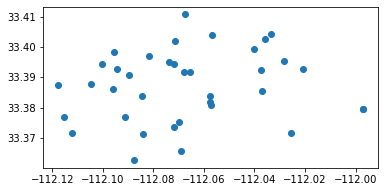

In [59]:
roosevelt_schools = gpd.sjoin(edge_gdf[~ edge_gdf['LEA Grade'].str.contains("12", na = False)], roosevelt)

roosevelt_schools.plot()

['Academy of Math and Science South Mountain' 'BASIS Phoenix South'
 'Bernard Black Elementary School' 'C J Jorgensen School'
 'EAGLE College Prep' 'Ed & Verma Pastor Elementary School'
 'Ignacio Conchos School' 'John R Davis School'
 'Southwest Elementary School' 'Sun Valley Academy'
 'Sunland Elementary School' 'V H Lassen Elementary School'
 'Valley View School' 'Victory High School - West Campus'
 'Amy L. Houston Academy' 'C O Greenfield School' 'Champion Schools'
 'Cloves C Campbell Sr Elementary School' 'George Gervin Prep Academy'
 'iAmRSDOnline Academy' 'John F Kennedy Elementary School'
 'Kaizen Education Foundation dba South Pointe Elementary Scho'
 'Maxine O Bush Elementary School' 'South Phoenix Prep and Arts Academy'
 'South Pointe Junior High School' 'South Valley Prep and Arts School'
 'T G Barr School' 'ASU Preparatory Academy - South Phoenix Intermediate'
 'ASU Preparatory Academy - South Phoenix Primary'
 'Cesar E Chavez Community School' 'EAGLE College Prep Phoenix S

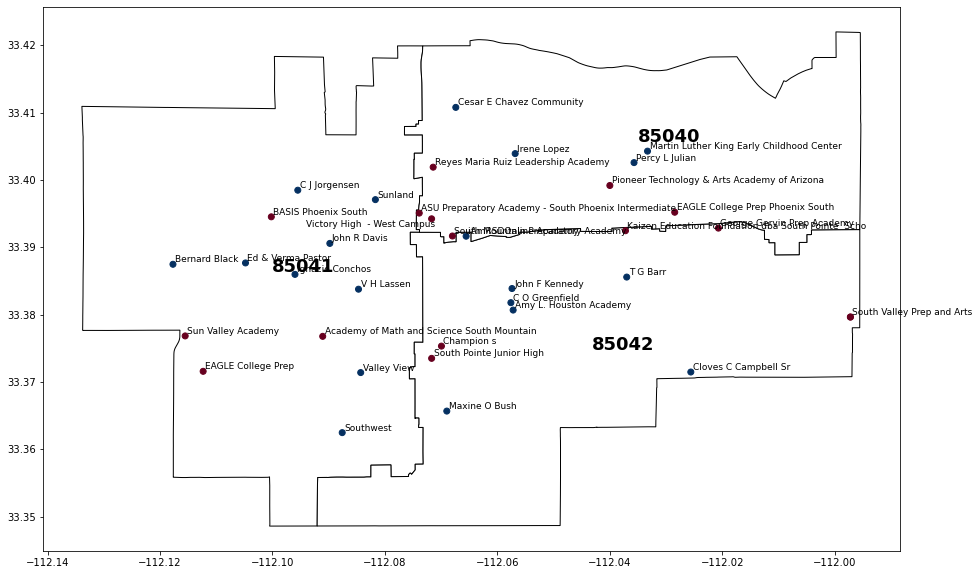

In [60]:
ax = roosevelt.plot(color="white", edgecolor="black", linewidth = 1, figsize=(18, 10))

for x, y, label in zip(roosevelt_points.geometry.x, roosevelt_points.geometry.y, roosevelt_points['ZCTA5CE20']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize = 18, weight = 'bold')
    
roosevelt_schools.plot(ax=ax, column = 'LEA Type', cmap = 'RdBu')

print(roosevelt_schools['School Name'].unique())

roosevelt_schools['School Name'] = roosevelt_schools['School Name'].str.replace("School","")
roosevelt_schools['School Name'] = roosevelt_schools['School Name'].str.replace("Schools","")
roosevelt_schools['School Name'] = roosevelt_schools['School Name'].str.replace("Elementary","")
roosevelt_schools['School Name'] = roosevelt_schools['School Name'].str.strip()

# roosevelt_schools['School Name'] = roosevelt_schools['School Name'].str.replace("South Phoenix Prep and Arts Academy","South Phoenix Prep and Arts ")

print(roosevelt_schools['School Name'].unique())

for x, y, label in zip(roosevelt_schools.geometry.x, roosevelt_schools.geometry.y, roosevelt_schools['School Name']):
    if label not in (['South Phoenix Prep and Arts Academy','ASU Preparatory Academy - South Phoenix Primary']):
        ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points", fontsize = 9)

# gpd.sjoin(roosevelt, edge_gdf[~ edge_gdf['LEA Grade'].str.contains("12", na = False)])\
#     .groupby(['ZCTA5CE20','LEA Type']).size().unstack()

# gpd.sjoin(roosevelt, edge_gdf[~ edge_gdf['LEA Grade'].str.contains("12", na = False)])\
#     .groupby(['ZCTA5CE20','LEA Type','LEA Name']).size()\
#     .unstack().transpose().fillna(0)

In [62]:
df3.columns

Index(['Attending LEA ID', 'Attending LEA Name', 'School Id', 'School Name',
       'Zip Code', 'Total ADM', 'grade'],
      dtype='object')

In [67]:
df3['grade'] = df3['Attending LEA ID'].map(ctd_adm_grade_dict)

df3[(df3['Zip Code'].isin(roosevelt_zip)) & (~ df3['grade'].str.contains("12", na = False))]\
    .groupby(['Attending LEA Name','School Name','Zip Code'])['Total ADM'].sum().unstack()\
    .sort_values(by = '85042', ascending = False).head(20)

Zip Code                                                                                                  85040  \
Attending LEA Name                                 School Name                                                    
Tempe School District                              Nevitt Elementary School                            128.7902   
Roosevelt Elementary District                      C O Greenfield School                               162.5888   
                                                   Cloves C Campbell Sr Elementary School              113.1878   
Tempe School District                              Gililland Middle School                             224.1599   
Roosevelt Elementary District                      Maxine O Bush Elementary School                          NaN   
                                                   T G Barr School                                      87.9450   
                                                   John F Kennedy Elementary School                    114.5946   
Fit Kids, Inc. dba Champion Schools                Champion Schools                                     53.5919   
South Phoenix Academy Inc.                         South Phoenix Prep and Arts Academy                  68.8098   
South Valley Academy, Inc.                         South Valley Prep and Arts School                    49.4212   
Tempe School District                              Fees College Preparatory Middle School               18.9100   
                                                   Frank Elementary School                                  NaN   
Kyrene Elementary District                         Kyrene Centennial Middle School                      16.0000   
Kaizen Education Foundation dba South Pointe El... Kaizen Education Foundation dba South Pointe El...  122.0361   
Kyrene Elementary District                         Kyrene de las Lomas School                           19.9550   
Roosevelt Elementary District                      Valley View School                                   15.2026   
Phoenix Education Management, LLC,                 Pioneer Technology & Arts Academy of Arizona        290.3663   
Academy of Mathematics and Science South, Inc.     Academy of Math and Science South Mountain           40.0807   
Kaizen Education Foundation dba South Pointe Ju... South Pointe Junior High School                      39.9049   
Legacy Traditional School – Laveen Village         Legacy Traditional School – Laveen Village               NaN   

Zip Code                                                                                                  85041  \
Attending LEA Name                                 School Name                                                    
Tempe School District                              Nevitt Elementary School                             14.0036   
Roosevelt Elementary District                      C O Greenfield School                                28.2299   
                                                   Cloves C Campbell Sr Elementary School               25.2849   
Tempe School District                              Gililland Middle School                                  NaN   
Roosevelt Elementary District                      Maxine O Bush Elementary School                      36.5400   
                                                   T G Barr School                                      27.0850   
                                                   John F Kennedy Elementary School                     21.9200   
Fit Kids, Inc. dba Champion Schools                Champion Schools                                    216.4635   
South Phoenix Academy Inc.                         South Phoenix Prep and Arts Academy                  38.8550   
South Valley Academy, Inc.                         South Valley Prep and Arts School                    39.2621   
Tempe School District                              Fees College Preparatory Middle School

<AxesSubplot:>

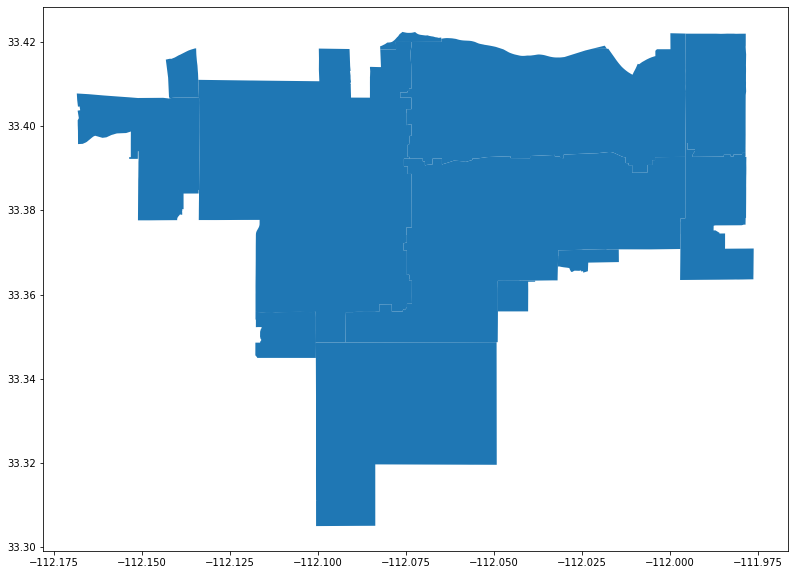

In [73]:
district_intersect_zip[district_intersect_zip['ZCTA5CE20'].isin(roosevelt_zip)].plot(figsize = (18,10))

## Roosevelt Zipcodes

<AxesSubplot:>

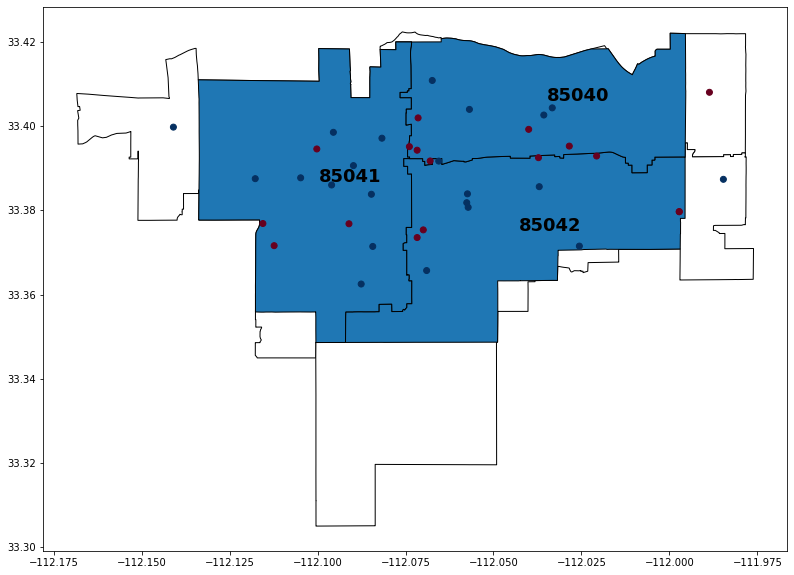

In [94]:

# zip_shape.to_crs('EPSG:4269',inplace = True)

ax = zip_shape[zip_shape['ZCTA5CE20'].isin(roosevelt_zip)].plot(color = 'white', edgecolor = 'black', figsize = (18,10))

roosevelt.plot(ax=ax, edgecolor = 'black')

for x, y, label in zip(roosevelt_points.geometry.x, roosevelt_points.geometry.y, roosevelt_points['ZCTA5CE20']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize = 18, weight = 'bold')
    
roosevelt_zip_schools = gpd.sjoin(edge_gdf[~ edge_gdf['LEA Grade'].str.contains("12", na = False)], roosevelt_zips)

roosevelt_zip_schools.plot(ax = ax, column = 'LEA Type', cmap = 'RdBu')

In [104]:
kyrene = district_intersect_zip[(district_intersect_zip['NAME'].str.contains("Kyrene")) & (district_intersect_zip['pct_overlap'] >= .5)]

kyrene_zip = list(kyrene['ZCTA5CE20'].unique())

kyrene["center"] = kyrene["geometry"].centroid
kyrene_points = kyrene.copy()
kyrene_points.set_geometry("center", inplace = True)

C:\Users\matto\AppData\Local\Temp/ipykernel_8988/3263021625.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  kyrene["center"] = kyrene["geometry"].centroid


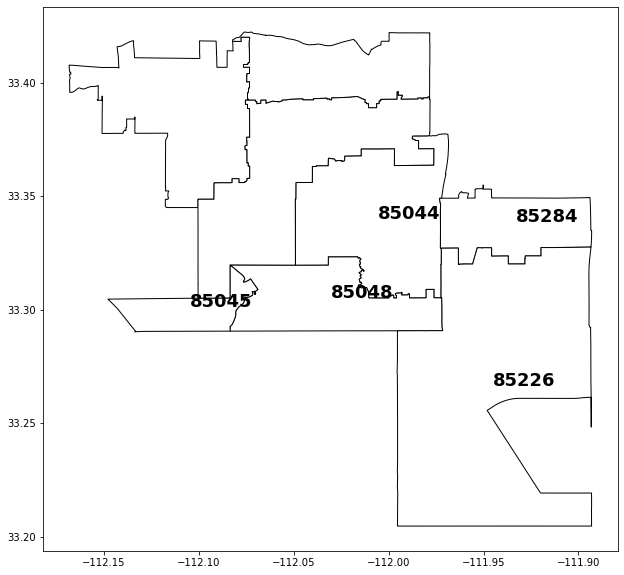

In [107]:
ax = zip_shape[(zip_shape['ZCTA5CE20'].isin(kyrene_zip)) | ((zip_shape['ZCTA5CE20'].isin(roosevelt_zip)))].plot(color = 'white', edgecolor = 'black', figsize = (18,10))

for x, y, label in zip(kyrene_points.geometry.x, kyrene_points.geometry.y, kyrene_points['ZCTA5CE20']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize = 18, weight = 'bold')


<AxesSubplot:>

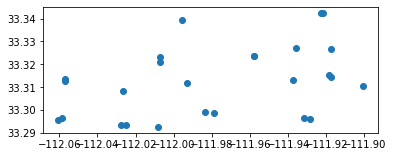

In [108]:
kyrene_schools = gpd.sjoin(edge_gdf[~ edge_gdf['LEA Grade'].str.contains("12", na = False)], kyrene)

kyrene_schools.plot()

In [117]:
bus_schools = kyrene_schools[kyrene_schools['State School ID'].astype(int).isin(bus_list)]

<AxesSubplot:>

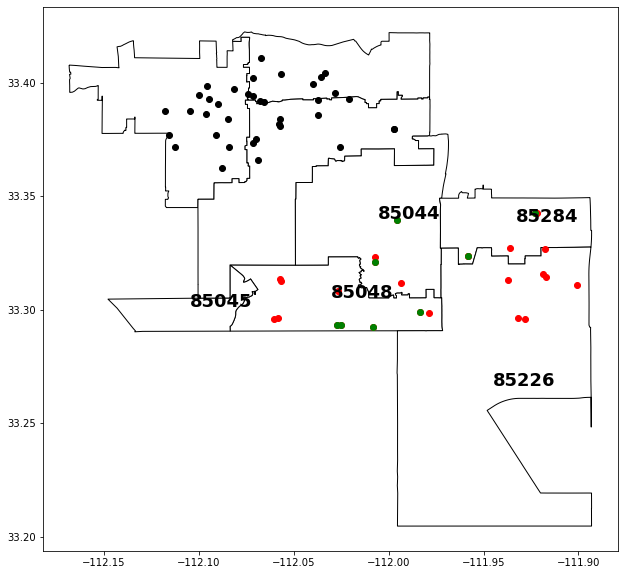

In [118]:
ax = zip_shape[(zip_shape['ZCTA5CE20'].isin(kyrene_zip)) | ((zip_shape['ZCTA5CE20'].isin(roosevelt_zip)))].plot(color = 'white', edgecolor = 'black', figsize = (18,10))

for x, y, label in zip(kyrene_points.geometry.x, kyrene_points.geometry.y, kyrene_points['ZCTA5CE20']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize = 18, weight = 'bold')

kyrene_schools.plot(ax = ax, color = 'red')
roosevelt_schools.plot(ax = ax, color = 'black')
bus_schools.plot(ax = ax, color = 'green')